<strong>Model Name: </strong> YOLOv3<br>
<strong>Dataset Link:</strong> https://evp-ml-data.s3.us-east-2.amazonaws.com/ml-interview/openimages-personcar/trainval.tar.gz<br>
<strong>Model Info:</strong> YOLOv3 is extremely fast and accurate. In mAP measured at 0.5 IOU YOLOv3 is on par with Focal Loss but about 4x faster. Moreover, you can easily tradeoff between speed and accuracy simply by changing the size of the model. The model uses three different scales for prediction which encounters the problem of different sizes of bounding box.<br>
<strong>Inference:</strong> Inference is done using Mean Average Precision (MAP) as a metric.

# Understanding Data

In [2]:
import json

data = json.load(open('trainval/annotations/bbox-annotations.json', 'rb'))
print(data.keys())

dict_keys(['images', 'annotations', 'categories', 'licenses'])


In [3]:
data['images'][0]

{'file_name': 'image_000000001.jpg',
 'width': 1024,
 'height': 768,
 'id': 0,
 'license': 1}

In [4]:
data['annotations'][1]

{'category_id': 1,
 'image_id': 0,
 'segmentation': [],
 'iscrowd': 0,
 'bbox': [848, 216, 175, 551],
 'area': 0.12261072794596355,
 'id': 1,
 'license': 2}

In [8]:
data['categories']

[{'id': 1, 'name': 'person', 'supercategory': 'none'},
 {'id': 2, 'name': 'car', 'supercategory': 'none'}]

In [9]:
data['licenses']

[{'url': 'https://creativecommons.org/licenses/by/2.0/',
  'id': 1,
  'name': 'Attribution License'},
 {'url': 'https://creativecommons.org/licenses/by/4.0/',
  'id': 2,
  'name': 'Attribution License'}]

In [10]:
import pandas as pd
images = pd.DataFrame(data['images'])
images.head()

,file_name,width,height,id,license
0,image_000000001.jpg,1024,768,0,1
1,image_000000002.jpg,1024,576,1,1
2,image_000000003.jpg,1024,683,2,1
3,image_000000004.jpg,1024,675,3,1
4,image_000000005.jpg,1024,926,4,1


In [11]:
annotations = pd.DataFrame(data['annotations'])
annotations.head()

,category_id,image_id,segmentation,iscrowd,bbox,area,id,license
0,1,0,[],0,"[846, 145, 146, 477]",0.088554,0,2
1,1,0,[],0,"[848, 216, 175, 551]",0.122611,1,2
2,2,0,[],0,"[74, 159, 75, 81]",0.007725,2,2
3,2,0,[],0,"[153, 124, 658, 643]",0.537992,3,2
4,1,1,[],0,"[488, 281, 28, 71]",0.003370,4,2


In [13]:
##conversion of bounding box from coco to pascal voc format
def coco_to_pascalvoc(bboxes):
    for i in range(len(bboxes)):
        x_min, y_min, width, height = bboxes[i]['bbox'] 
        x_max = x_min + width
        y_max = y_min + height
        bboxes[i]['bbox'] = [x_min, y_min, x_max, y_max]
    return bboxes

##filtering valid bounding boxes
def get_valid_bboxes(bboxes, img_width, img_height):
    validated_bboxes = []
    for bbox in bboxes:
        x_min, y_min, x_max, y_max = bbox['bbox']
        if x_min >= 0 and y_min >= 0 and x_max >=0 and y_max >=0 and x_max <= img_width and y_max <= img_height and x_min <= img_width and y_min <= img_height and x_min!=x_max and y_min!=y_max:
            validated_bboxes.append(bbox)
    return validated_bboxes

In [28]:
##
final_data = []
for i in range(len(data['images'])):
    image = data['images'][i]
    bboxes = annotations[annotations['image_id'] == image['id']][['bbox', 'iscrowd', 'segmentation', 'category_id', 'area']].to_json(orient = 'index')
    bboxes = list(json.loads(bboxes).values())
    bboxes = coco_to_pascalvoc(bboxes)
    image['bboxes'] = get_valid_bboxes(bboxes, image['width'], image['height'])
    final_data.append(image)

with open('train_instance.json', "w") as outfile:  
    json.dump(final_data, outfile, indent = 1)    

In [29]:
final_data[0]

{'file_name': 'image_000000001.jpg',
 'width': 1024,
 'height': 768,
 'id': 0,
 'license': 1,
 'bboxes': [{'bbox': [846, 145, 992, 622],
   'iscrowd': 0,
   'segmentation': [],
   'category_id': 1,
   'area': 0.0885543823},
  {'bbox': [848, 216, 1023, 767],
   'iscrowd': 0,
   'segmentation': [],
   'category_id': 1,
   'area': 0.1226107279},
  {'bbox': [74, 159, 149, 240],
   'iscrowd': 0,
   'segmentation': [],
   'category_id': 2,
   'area': 0.007724762},
  {'bbox': [153, 124, 811, 767],
   'iscrowd': 0,
   'segmentation': [],
   'category_id': 2,
   'area': 0.5379918416}]}

# Anchor Creation using kmeans

In [12]:
import json
import cv2
import numpy as np

wh = []
net_h, net_w = 416, 416
final_data = json.load(open('train_instance.json', 'r'))
for data_pt in final_data:
    img = cv2.imread(f"trainval/images/{data_pt['file_name']}")
    bboxes = [bbox['bbox'] for bbox in data_pt['bboxes']]
    _, scaled_bboxes = resize(img, bboxes, net_h, net_w)
    for box in scaled_bboxes:
        x_min, y_min, x_max, y_max = box
        width = x_max - x_min
        height = y_max - y_min
        wh.append((width, height))

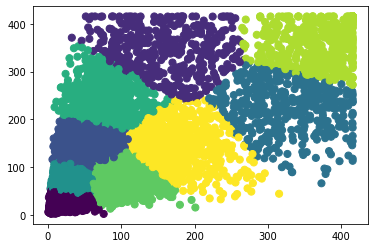

In [14]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

wh = np.array(wh)
x, y = wh[:, 0], wh[:, 1]
model = KMeans(9, random_state=1)
model.fit(wh)
plt.scatter(x, y, c=model.labels_,
            s=50, cmap='viridis');

In [19]:
anchors = model.cluster_centers_.astype('int')
anchor_areas = anchors[:, 0]*anchors[:, 1]
sorted(zip(anchor_areas, anchors))

[(459, array([17, 27])),
 (1944, array([27, 72])),
 (6116, array([ 44, 139])),
 (6440, array([92, 70])),
 (17424, array([ 72, 242])),
 (24850, array([175, 142])),
 (54060, array([159, 340])),
 (71928, array([324, 222])),
 (134664, array([372, 362]))]

In [4]:
import json
from sklearn.model_selection import train_test_split

train_inst = json.load(open('train_instance.json', 'r'))

train_inst, test_inst = train_test_split(train_inst, random_state = 0, test_size = 0.1)
train_inst, valid_inst = train_test_split(train_inst, random_state = 0, test_size = 0.1)
json.dump(train_inst, open('trainval/train.json', 'w'), indent = 2)
json.dump(valid_inst, open('trainval/val.json', 'w'), indent = 2)
json.dump(test_inst, open('trainval/test.json', 'w'), indent = 2)
print('Train size:', len(train_inst))
print('Val size:', len(valid_inst))
print('Test size:', len(test_inst))

Train size: 1813
Val size: 202
Test size: 224


In [1]:
import json

batch_size = 4
base_path = 'trainval/images'
checkpoint_path = 'yolo_v3/checkpoint/yolov3_4.h5'
train_inst = json.load(open('trainval/train.json', 'r'))
val_inst = json.load(open('trainval/val.json', 'r'))
test_inst = json.load(open('trainval/test.json', 'r'))

# Training

In [1]:
from yolo_v3.main import YoloV3

model_obj = YoloV3(training = True)
model_obj.train(train_inst, val_inst, base_path, batch_size, checkpoint_path)

Epoch 1/100
453/453 [==============================] - ETA: 0s - loss: 67.3180    
Epoch 00001: val_loss improved from inf to 42.01369, saving model to yolo_v3/checkpoint/yolov3_4.h5
453/453 [==============================] - 305s 674ms/step - loss: 67.3180 - val_loss: 42.0137 - lr: 0.0010
Epoch 2/100
453/453 [==============================] - ETA: 0s - loss: 40.7881  
Epoch 00002: val_loss improved from 42.01369 to 40.37061, saving model to yolo_v3/checkpoint/yolov3_4.h5
453/453 [==============================] - 312s 689ms/step - loss: 40.7881 - val_loss: 40.3706 - lr: 0.0010
Epoch 3/100
453/453 [==============================] - ETA: 0s - loss: 39.2679  
Epoch 00003: val_loss did not improve from 40.37061
453/453 [==============================] - 306s 675ms/step - loss: 39.2679 - val_loss: 41.5828 - lr: 0.0010
Epoch 4/100
453/453 [==============================] - ETA: 0s - loss: 37.4521  
Epoch 00004: val_loss improved from 40.37061 to 37.06414, saving model to yolo_v3/checkpoint/

# Testing

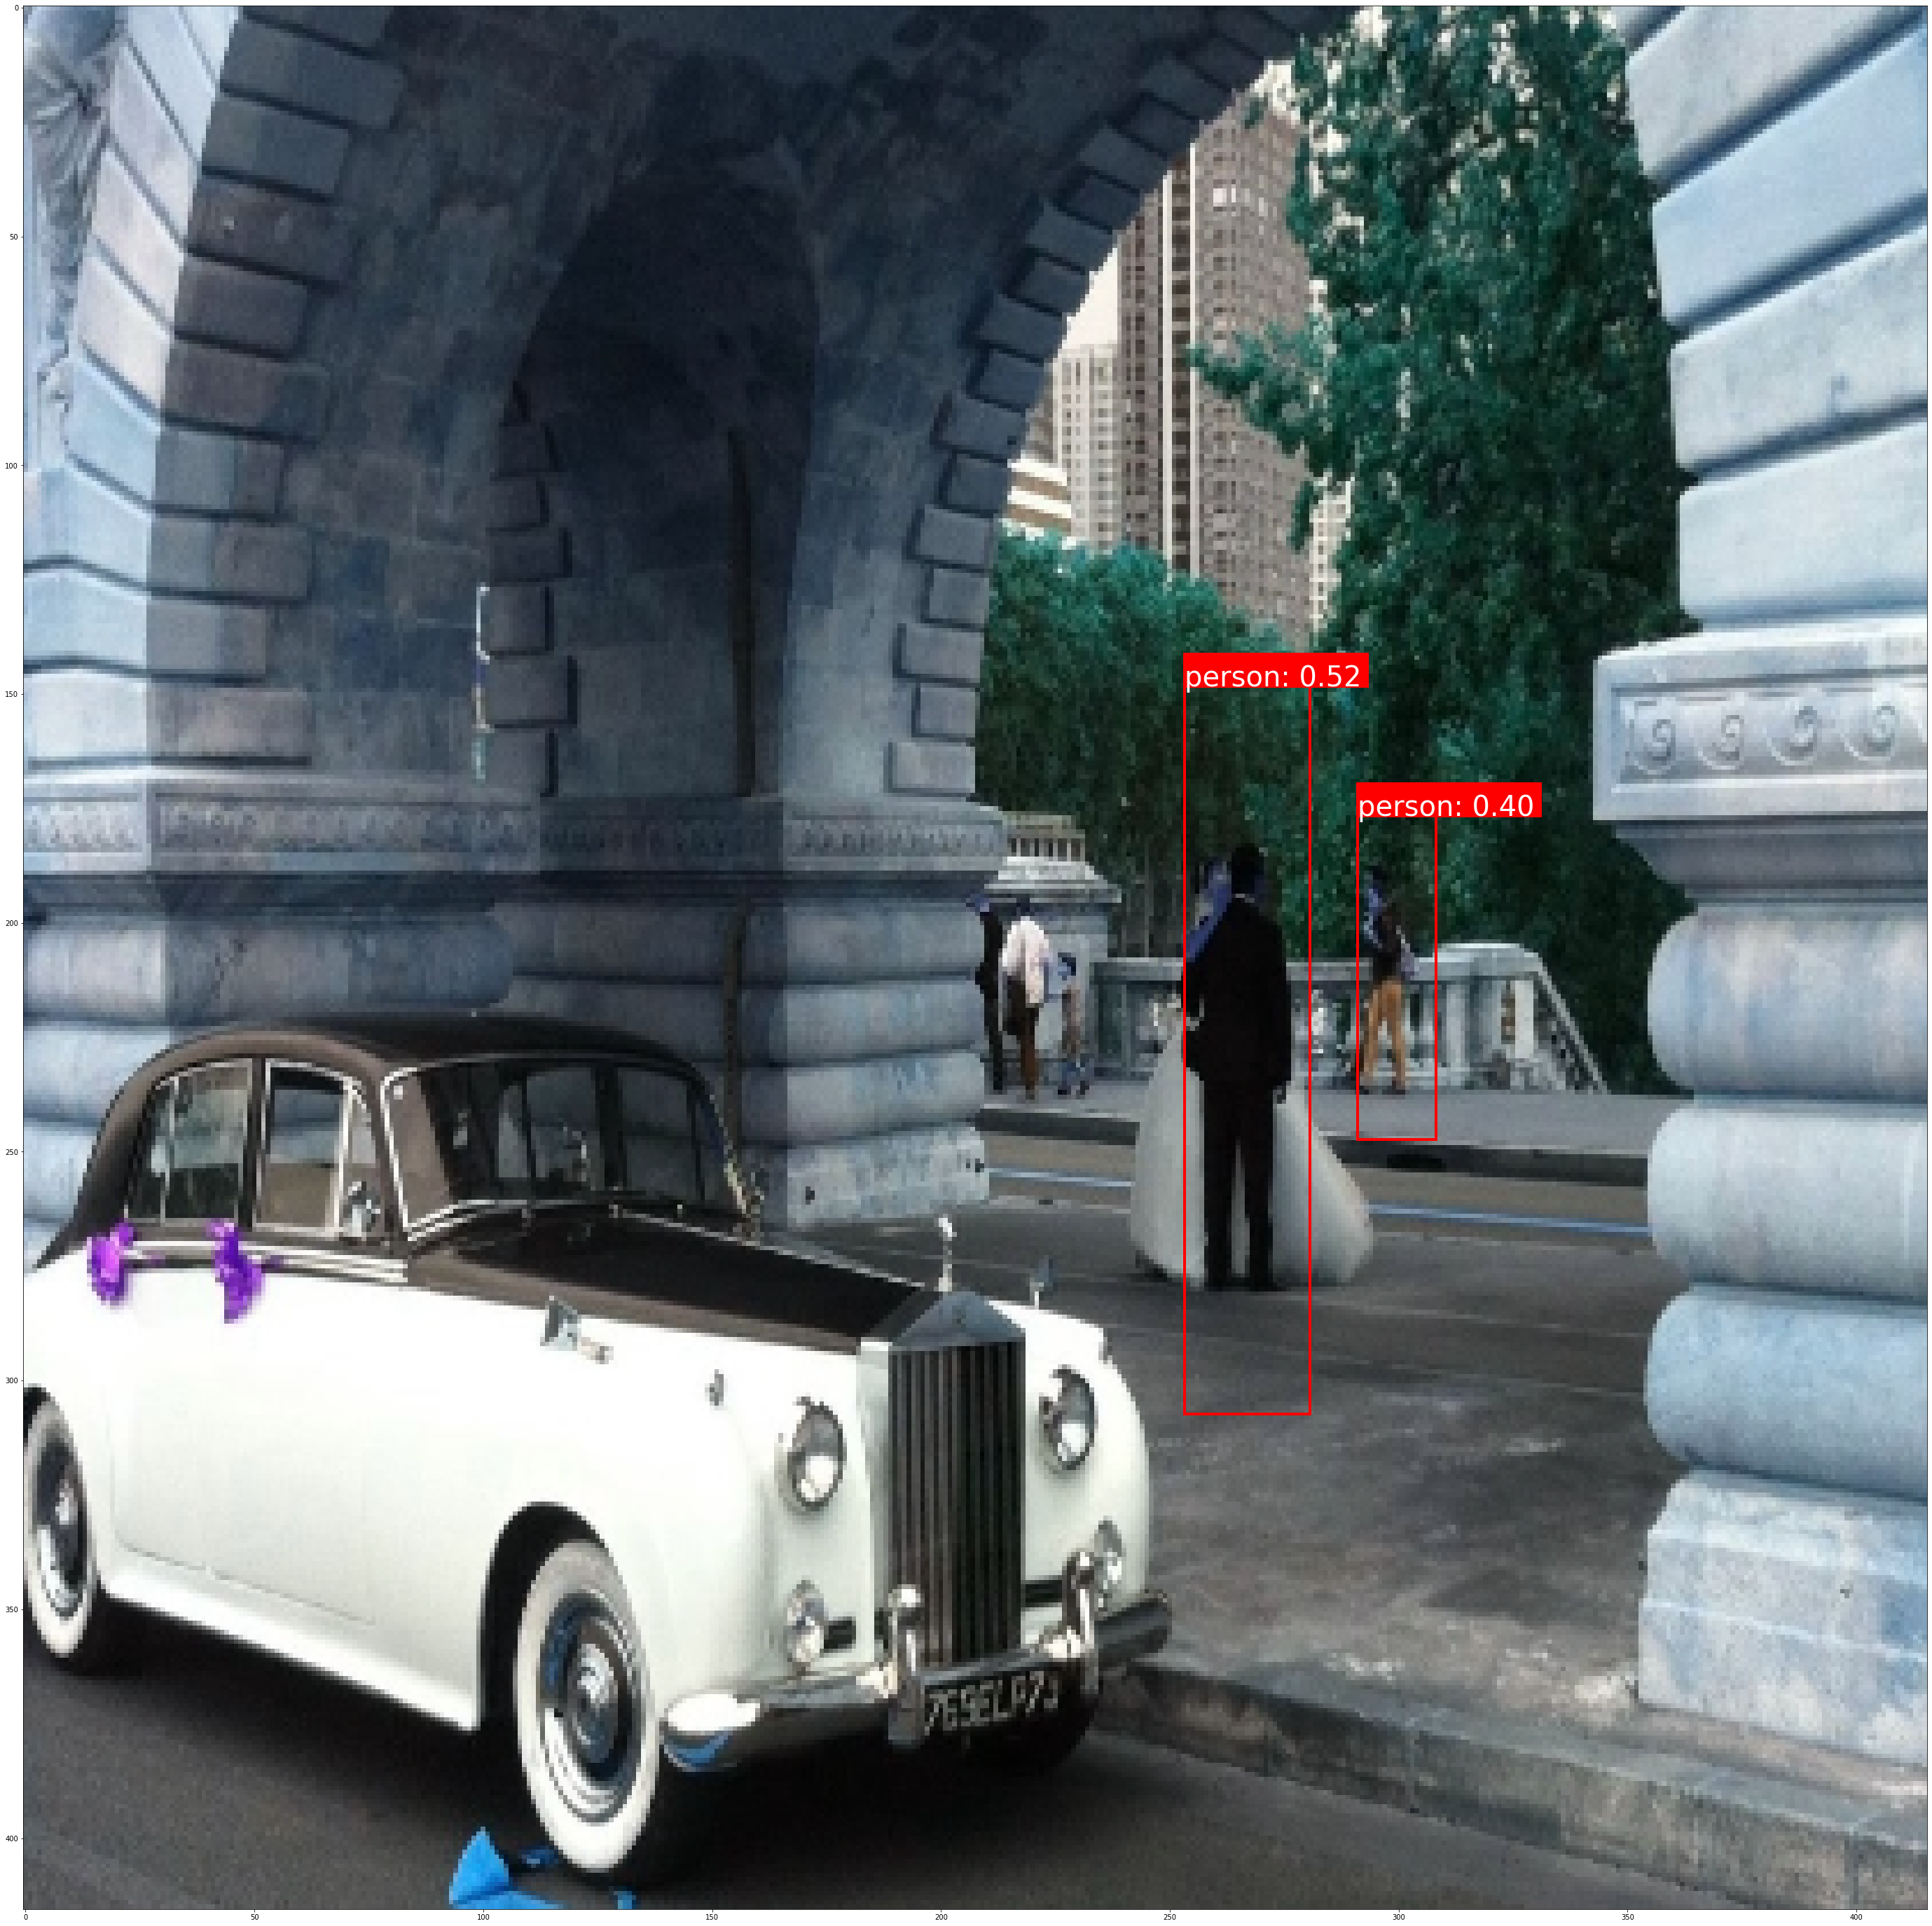

In [3]:
from yolo_v3.main import YoloV3

model_obj = YoloV3(model_weight_path = 'yolo_v3/checkpoint/yolov3_4.h5', training = False)
_ = model_obj.predict_img(f"trainval/images/{test_inst[3]['file_name']}", show = True)        

# Inference

In [2]:
import json
import numpy as np
from tqdm import tqdm
from yolo_v3.main import YoloV3
from yolo_v3.utils.metrics import get_map

iou_thresh = 0.5
num_classes = 2
base_path = 'trainval/images'
test_inst = json.load(open('trainval/test.json', 'r'))
model_obj = YoloV3(model_weight_path = 'yolo_v3/checkpoint/yolov3_4.h5', training = False)
map_ = model_obj.evaluate(test_inst, base_path, iou_thresh)
print('MAP@0.5:', map_)

100%|████████████████████████████████████████████████████████████████████████████████| 224/224 [00:16<00:00, 13.52it/s]

MAP@0.5: 0.0


<strong>Conclusion:</strong> The model has map of 0 as we need to tune hyper parameters thoroughly and need to train model with high batch size such as 12+.

<strong>Recommendations:</strong><br> 1. Hyper-parameter tuning needs to be done thoroughly with parameters such as iou loss threshold, nms threshold, objectness threshold, etc.<br>2. Model needs to be modified according to multi scale objects as cars and persons have high difference in sizes.<br>3. Train model with high batch size.